In [1]:
from __future__ import print_function
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

# 目标
- 学习基于标记的分水岭图像分割算法。
- 涉及函数：**cv2.watershed()**

# 1. 理论
任何一幅灰度图像都可以被看作是一张地形图，亮度高的地方描述山峰，亮度低的地方描述峡谷。首先用不同颜色的水（标签）填充所有独立的山谷（局部最小值）。当水位上涨时，依赖于附近的山峰（梯度），不同颜色的山谷将开始合并。为了避免这一情况，在不同颜色的水汇合的位置修筑堤坝。继续加水修筑堤坝直到所有的山峰都被淹没。这些堤坝就给出了分割的结果。这就是分水岭算法背后的哲学。可以访问[CMM webpage on watershed](http://cmm.ensmp.fr/~beucher/wtshed.html)观看动画来加深理解。

但是这种算法通常会受到图像中噪声的影响得到过分割的结果。在OpenCV中实现了基于标记的分水岭算法，在这种算法中需要指定哪些山谷需要合并，哪些不需要。这是一种交互式的图像分割算法。在调用算法时需要为已知的目标指定标签。对确信为目标的区域标记为一种颜色，对确信为背景的区域标记为另一种颜色，最后将不确定的区域的标签置为0。然后根据标记应用分水岭算法，然后标记将根据标签进行更新，目标的边界的值置为-1。

# 2. 代码
下面的例子中将看到如何使用带有距离变换的分水岭算法来分割互相接触的目标。

考虑下面的硬币图像，硬币之间互相接触，即使使用阈值操作也无法将其分开。![](./imgs/water_coins.jpg)

下面开始计算硬币的近似估计，下面的代码使用了Otsu二值化：

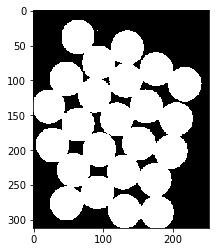

In [2]:
img = cv2.imread('../data/coins.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

plt.imshow(thresh, 'gray')

现在需要移除图像中小的白噪声，为了实现这一目标可以使用形态学开操作。若要移除目标中的小洞，可以使用形态学闭操作。目标中心附近的区域确信属于前景，而远离目标的区域则是背景。不确定的区域是硬币的边界区域。

接下来需要提取确信是硬币的区域，可以用腐蚀操作移除目标的边界像素，此时剩下的区域确信是硬币。但是要保证这一方法可行，要求目标之间不能接触。但是由于目标之间相互接触，更好的选择是计算距离变换，然后再应用一个适当的阈值操作。然后计算确信没有硬币的区域，这一步要用到膨胀操作，膨胀操作增加了目标的面积，这样可以确保我们标记的背景区域确实是背景区域，这是因为把边界区域从背景中移除了。如下图所示：![](./imgs/water_fgbg.jpg)

剩下的区域无法确定其属于硬币还是背景，然后用分水岭算法来计算。这些区域通常位于目标的边界（可能是前景和背景的边界、也可能是硬币和硬币的边界）。可以从图像中减去确信的前景区域和确信的背景区域得到。

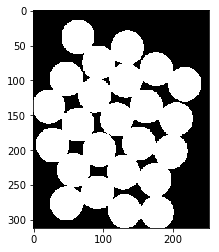

In [3]:
# 移除噪声
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)

plt.imshow(opening, 'gray')

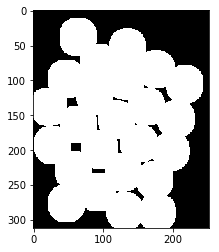

In [4]:
# 确信为背景的区域
sure_bg = cv2.dilate(opening, kernel, iterations=3)

plt.imshow(sure_bg, 'gray')

(<matplotlib.axes._subplots.AxesSubplot at 0x2052fc3b828>,
 <matplotlib.image.AxesImage at 0x20533dca748>)

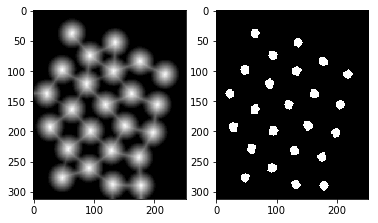

In [5]:
# 计算确信为前景的区域
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, cv2.THRESH_BINARY)

plt.subplot(121), plt.imshow(dist_transform, 'gray')
plt.subplot(122), plt.imshow(sure_fg, 'gray')

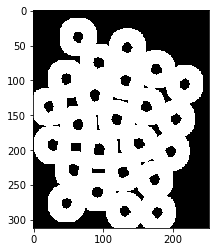

In [6]:
# 计算未知区域
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

plt.imshow(unknown, 'gray')

通过上面的结果可以看到，得到了确信为硬币的区域，而且他们之间是分离的。（如果只需要对前景进行分割，而不是分割互相接触的目标，此时无需使用距离变换，只用腐蚀操作就足够了。腐蚀操作是另一种提取前景区域的方法。

现在，已经得到了确信为硬币的区域和确信为背景的区域。接下来创建标记（标记是与原图像相同大小的数组，但是其数据类型为int32）和区域的标签。确信的区域（无论是目标还是背景）设置为不同的正整数，不确信的区域设置为0。可以用**cv2.connectedComponents()**函数，该函数将背景区域设置为0，其他的目标的标签值从1开始。

但是分水岭算法中标签为0的区域被认为是不确定的区域，因此要把背景区域设定为其他整数，然后将未知区域设置为0。

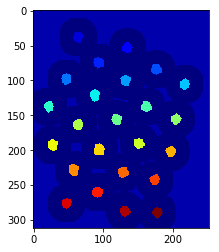

In [7]:
# 标记标签
ret, markers = cv2.connectedComponents(sure_fg)

# 将所有的标签加1，使得背景被标记为1
markers = markers + 1

# 将未知区域设置为0
markers[unknown == 255] = 0

plt.imshow(markers, 'jet')

上图的结果中，深蓝色的区域表示未知区域，确认的硬币区域用不同的颜色标记，浅一点的蓝色区域是背景区域。

现在标记已经准备好了，接下来执行最后一步：分水岭算法。然后标记会被改变，边界区域会被置为-1。

(<matplotlib.axes._subplots.AxesSubplot at 0x20533cfce48>,
 <matplotlib.image.AxesImage at 0x20533f4bac8>)

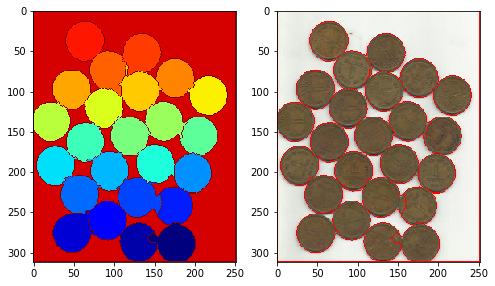

In [8]:
markers = cv2.watershed(img, markers)
img[markers == -1] = [0, 0, 255]

plt.figure(1, (8, 8))
plt.subplot(121), plt.imshow(markers, 'jet_r')
plt.subplot(122), plt.imshow(img[:, :, ::-1])

# 3. 额外资源
1. CMM page on [Watershed Transformation](http://cmm.ensmp.fr/~beucher/wtshed.html)

# 4. 练习
1. OpenCV提供了一个交互式的分水岭分割的例子[(download)](./ref/watershed.py)，可以试着运行、学习。